In [1]:
import pandas as pd
import importlib
import sys
from tqdm import tqdm
import time
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import contextily as cx
from datetime import datetime, timedelta

In [2]:
from readers.InSAR import InSAR
from readers.GNSS import GNSS

In [4]:
insar = InSAR('data/InSAR_data/time_series_Saarland_Orbit139_update.nc')
gnss = GNSS('data/selected_stations_dates.csv')
master_day = insar.get_master_day()
gnss.compute_standarized_dataset_up(master_day)

/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:84: UserWarning: BIWI does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:84: UserWarning: D525 does not have data for 6625. Using closest day 5920 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:84: UserWarning: LUX1 does not have data for 6625. Using closest day 6820 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:84: UserWarning: MOLV does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:84: UserWarning: MOUS does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:84: UserWarning: OBER does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:84: UserWarning: SI

In [5]:
def plot_insar_gnss_closest(insar, gnss, insar_index):
    insar_df = insar.get_df()
    gnss_df_standarized = gnss.get_df()
    lon = insar_df.iloc[insar_index]['longitude']
    lat = insar_df.iloc[insar_index]['latitude']
    closest_gnss = gnss.get_closest_site(lon, lat)
    
    plt.figure(figsize=(15,15))
    plt.subplot(2,2,1)
    InSAR.plot_insar_series(insar_df,insar_index)
    
    plt.subplot(2,2,2)
    GNSS.plot_gnss_series(gnss_df_standarized, closest_gnss.name, 'st_up(mm)')
    
    plt.subplot(2,2,3)
    bbox = insar.get_bbox()
    ax = plt.gca()
    gpd.GeoSeries(bbox).plot(ax=ax, color='green', alpha=0.2)
    gpd.GeoSeries(closest_gnss.geometry).plot(ax=ax, markersize=12)
    gpd.GeoSeries(Point(lon, lat)).plot(ax=ax, markersize=12, color='red')
    ax.text(closest_gnss.geometry.x,
            closest_gnss.geometry.y,
            closest_gnss.name,
            fontsize=8, ha='center', va='top')
    cx.add_basemap(ax=ax, crs = 'EPSG:4326', attribution='')
    
    plt.subplot(2,2,4)
    days = insar.get_days()
    x = pd.to_datetime(days, origin='2000-01-01', unit='D')
    cols = [c for c in insar_df.columns if c.startswith('day_')]
    insar_y = insar_df.iloc[insar_index][cols].values
    plt.plot(x, insar_y, label = 'InSAR')
    selected_site_data = gnss_df_standarized[gnss_df_standarized['site'] == closest_gnss.name]
    gnss_selected_dates = selected_site_data[selected_site_data['day'].isin(days)]
    plt.plot(pd.to_datetime(gnss_selected_dates['day'], origin='2000-01-01', unit='D'), gnss_selected_dates['st_up(mm)'], label = 'GNSS')
    plt.legend()
    plt.xticks(rotation=45)
    plt.title(f"InSAR and GNSS data for days with InSAR data")
    plt.ylabel("Vertical displacement (mm)")
    plt.show()


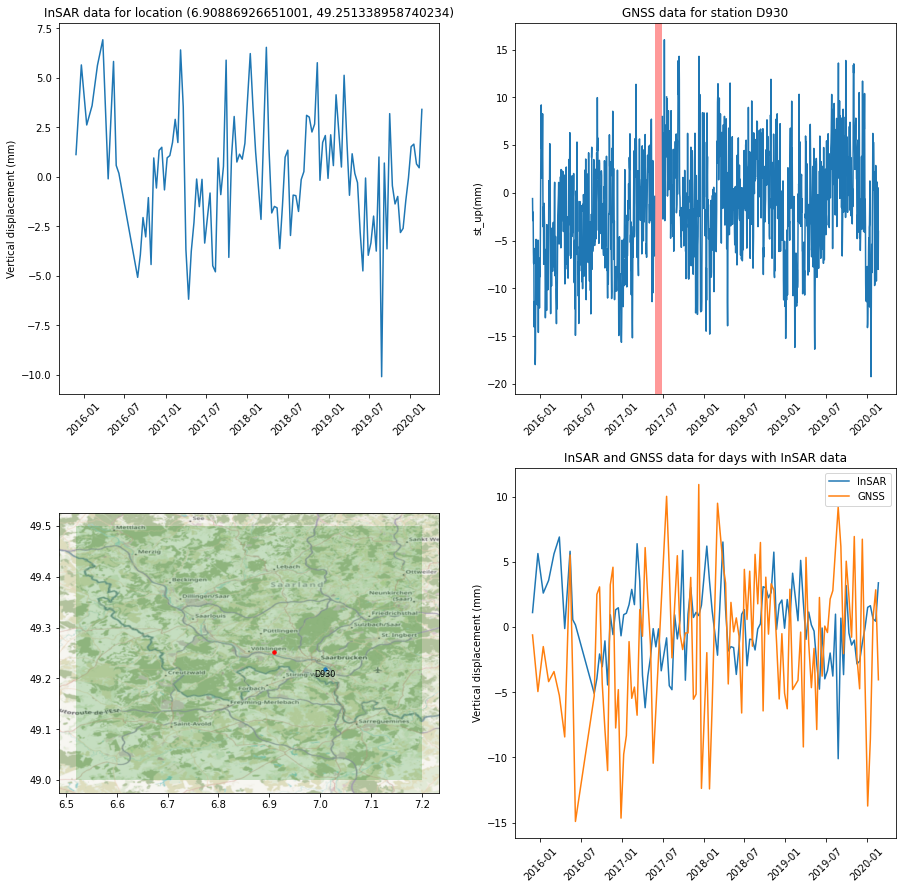

In [6]:
plot_insar_gnss_closest(insar, gnss, 100000)

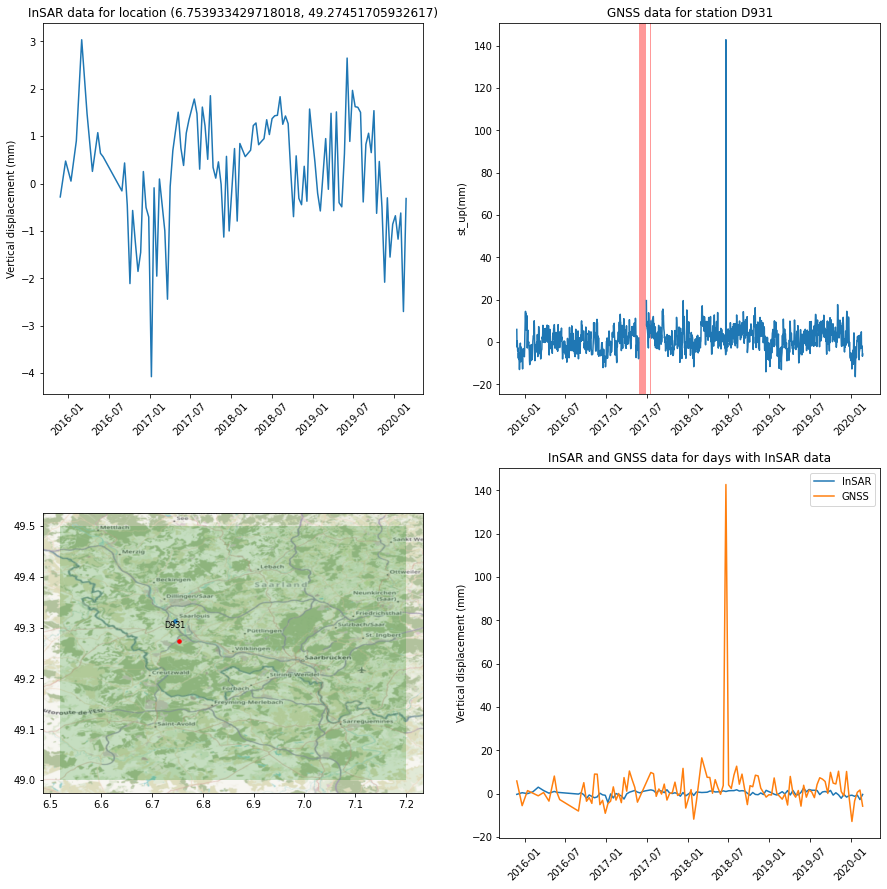

In [7]:
plot_insar_gnss_closest(insar, gnss, 105000)

In [8]:
insar_df = insar.get_df()
gnss_df = gnss.get_df()

In [9]:
lon = insar_df.iloc[0]['longitude']
lat = insar_df.iloc[0]['latitude']

In [10]:
closest = gnss.get_closest_site(lon, lat)

In [11]:
closest

_longitude(deg)                                         6.29158
_latitude(deg)                                        49.203947
geometry           POINT (6.291580000087519 49.203946667936535)
distance(m)                                        28043.399379
Name: VIGY, dtype: object

In [12]:
gnss_df_standarized = gnss.get_df()

In [13]:
first_day, last_day = insar.get_first_and_last_day()
all_days = list(range(first_day, last_day+1, 1))

In [14]:
gnss_sites = gnss_df.groupby('site').agg({'_longitude(deg)': 'mean', '_latitude(deg)': 'mean'})
gnss_sites['count'] = gnss_df.groupby('site')['day'].count()
gnss_sites['coverage'] = gnss_sites['count'] / (last_day-first_day+1)

In [15]:
gnss_sites_gdf = GNSS.get_gdf(gnss_sites)

In [16]:
bbox = insar.get_bbox()

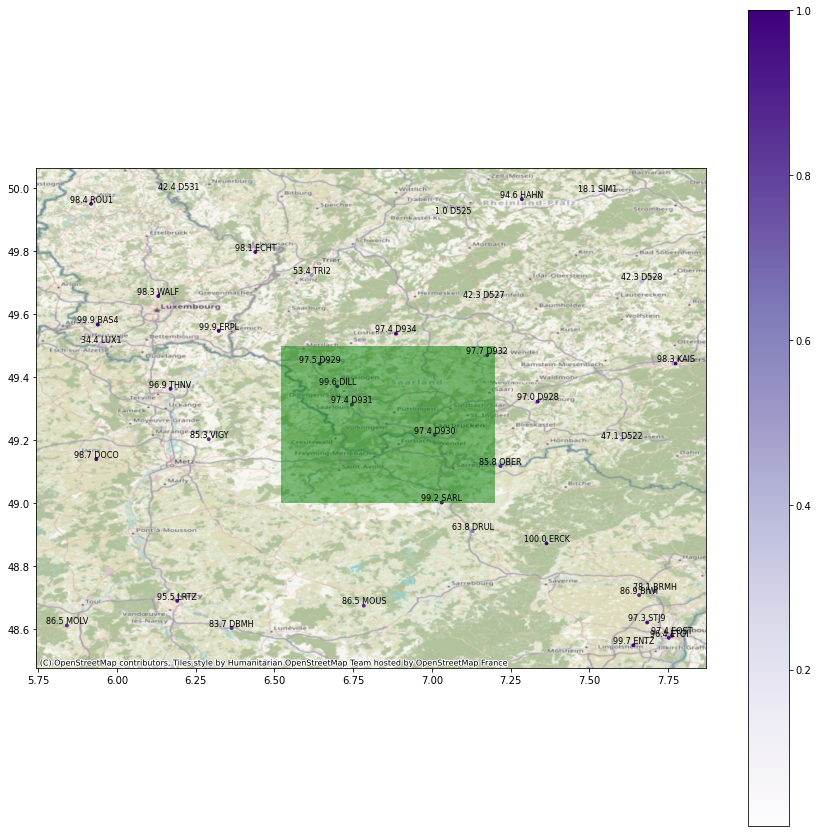

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gnss_sites_gdf.plot(ax=ax, column='coverage', marker='o', markersize=8, legend=True, cmap='Purples')
gpd.GeoSeries(bbox).plot(ax=ax, color='green', alpha=0.5)
# Add text labels for 'coverage' next to each point
for x, y, coverage, site in zip(gnss_sites_gdf.geometry.x,
                                gnss_sites_gdf.geometry.y,
                                round(gnss_sites_gdf['coverage']*100,1),
                                gnss_sites_gdf.index
                               ):
    ax.text(x, y, str(coverage) + ' ' + site, fontsize=8, ha='center', va='bottom')

cx.add_basemap(ax=ax, crs = gnss_sites_gdf.crs)
plt.show()

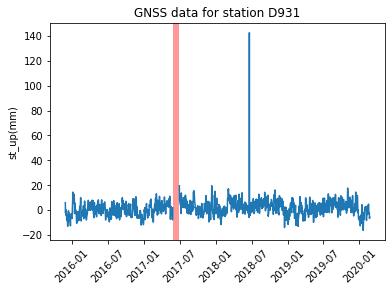

In [19]:
GNSS.plot_gnss_series(gnss_df_standarized, 'D931', 'st_up(mm)')

This one shows a clear outlier, maybe it would be interesting to think about a way to detect them?

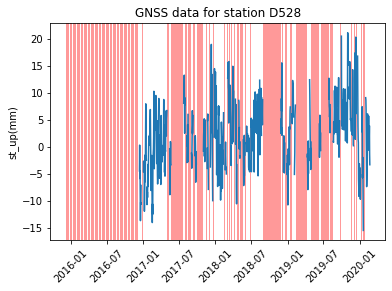

In [20]:
GNSS.plot_gnss_series(gnss_df_standarized, 'D528', 'st_up(mm)')

This one has a lot of missing dates, we need a way to think on how to deal with them

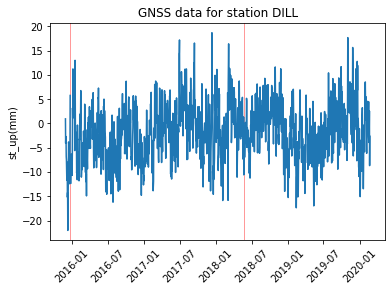

In [21]:
GNSS.plot_gnss_series(gnss_df_standarized, 'DILL', 'st_up(mm)')

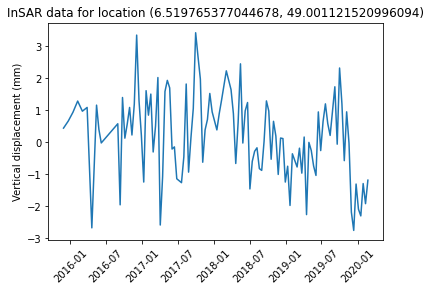

In [22]:
InSAR.plot_insar_series(insar_df,0)

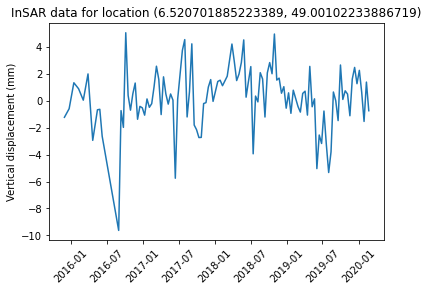

In [23]:
InSAR.plot_insar_series(insar_df,1)